# Previsão de Consumo de Energia com RNN (LSTM)

Este notebook demonstra como usar **Redes Neurais Recorrentes (RNN)**, especificamente uma camada **LSTM**,
para prever o consumo de energia ativa (`Global_active_power`) em uma residência,
usando o dataset **Household Electric Power Consumption** disponível no Kaggle/UCI.

---

## 1. Descrição do Dataset

O dataset contém medições de consumo elétrico de uma residência em intervalos de 1 minuto ao longo de ~4 anos.  
As colunas principais são:

- **Date/Time**: Data e hora da medição.  
- **Global_active_power**: Potência ativa global (kW).  
- **Global_reactive_power**: Potência reativa global (kW).  
- **Voltage**: Voltagem (V).  
- **Global_intensity**: Corrente elétrica (A).  
- **Sub_metering_1**: Consumo da cozinha (Wh).  
- **Sub_metering_2**: Consumo da lavanderia (Wh).  
- **Sub_metering_3**: Consumo do aquecedor/ar-condicionado (Wh).  

---

## 2. Métrica de Avaliação

Escolhemos a **RMSE (Root Mean Squared Error)**.  

- Mede o erro médio entre valores previstos e reais.  
- Penaliza erros grandes mais fortemente do que o MAE.  
- É útil em séries temporais de energia, onde picos de consumo são importantes e devem ser previstos com precisão.  
- A unidade é a mesma da variável prevista (kW), o que facilita a interpretação.  

---

## 3. Pipeline de Modelagem

1. **Pré-processamento**  
   - Carregar o dataset.  
   - Unir as colunas `Date` e `Time` em um índice temporal.  
   - Tratar valores ausentes e converter para amostras horárias.  

2. **Transformação em formato supervisionado**  
   - Usar as últimas 24 horas de consumo (`Global_active_power`) para prever a próxima hora.  

3. **Divisão em treino e teste**  
   - 80% para treino, 20% para teste.  

4. **Modelo RNN (LSTM)**  
   - Camada LSTM com 50 unidades.  
   - Camada densa de saída.  

5. **Treinamento e avaliação**  
   - Função de perda: MSE.  
   - Métrica final: RMSE no conjunto de teste.  

In [4]:
# ==============================
# 1. Imports e Carregamento de Dados
# ==============================
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Carregar dataset (baixado do Kaggle/UCI)
# O arquivo original vem como .txt separado por ";"
data = pd.read_csv(
    "/content/household_power_consumption.txt",
    sep=";",
    parse_dates={"Datetime": ["Date", "Time"]},
    dayfirst=True,
    infer_datetime_format=True,
    na_values=["?"]
)

# Definir índice como datetime
data.set_index("Datetime", inplace=True)

# Converter para valores numéricos e preencher faltantes
data = data.apply(pd.to_numeric, errors="coerce")
data = data.resample("H").mean().ffill()  # usar média por hora e preencher faltantes


/tmp/ipython-input-4064104951.py:11: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(
/tmp/ipython-input-4064104951.py:11: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(
/tmp/ipython-input-4064104951.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample("H").mean().ffill()  # usar média por hora e preencher faltantes


## 4. Criação do Conjunto Supervisionado

Para prever o próximo valor, usamos uma janela deslizante:  
- **Entrada (X):** valores das últimas 24 horas.  
- **Saída (y):** valor da 25ª hora (próxima).  

In [5]:
# ==============================
# 2. Função para criar dataset supervisionado
# ==============================
def create_dataset(series, n_lag=24):
    X, y = [], []
    for i in range(len(series) - n_lag):
        X.append(series[i:(i + n_lag)])
        y.append(series[i + n_lag])
    return np.array(X), np.array(y)

# Usar apenas a variável alvo: Global_active_power
series = data["Global_active_power"].values

n_lag = 24  # usar 24 horas passadas
X, y = create_dataset(series, n_lag)

# Ajustar formato para RNN (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão treino/teste
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Formato dos dados:", X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Formato dos dados: (27652, 24, 1) (27652,) (6913, 24, 1) (6913,)


## 5. Construção do Modelo LSTM

Criamos um modelo simples com:
- Uma camada **LSTM** com 50 unidades.  
- Uma camada densa final com 1 neurônio (previsão).  

In [6]:
# ==============================
# 3. Modelo RNN LSTM
# ==============================
model = Sequential()
model.add(LSTM(50, activation="relu", input_shape=(n_lag, 1)))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mse")

# Treinar modelo
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=72,
    validation_data=(X_test, y_test),
    verbose=2
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
385/385 - 6s - 15ms/step - loss: 0.5222 - val_loss: 0.2777
Epoch 2/10
385/385 - 2s - 4ms/step - loss: 0.3848 - val_loss: 0.2656
Epoch 3/10
385/385 - 3s - 7ms/step - loss: 0.3723 - val_loss: 0.2593
Epoch 4/10
385/385 - 2s - 5ms/step - loss: 0.3652 - val_loss: 0.2706
Epoch 5/10
385/385 - 2s - 4ms/step - loss: 0.3658 - val_loss: 0.2684
Epoch 6/10
385/385 - 2s - 4ms/step - loss: 0.3600 - val_loss: 0.2579
Epoch 7/10
385/385 - 2s - 4ms/step - loss: 0.3615 - val_loss: 0.2523
Epoch 8/10
385/385 - 2s - 4ms/step - loss: 0.3571 - val_loss: 0.2550
Epoch 9/10
385/385 - 2s - 4ms/step - loss: 0.3557 - val_loss: 0.2559
Epoch 10/10
385/385 - 2s - 4ms/step - loss: 0.3556 - val_loss: 0.2541


## 6. Avaliação do Modelo

Após o treinamento, calculamos o **RMSE** no conjunto de teste.

In [7]:
# ==============================
# 4. Avaliação do Modelo
# ==============================
preds = model.predict(X_test)

mse = np.mean((preds.flatten() - y_test) ** 2)
rmse = np.sqrt(mse)

print(f"RMSE no conjunto de teste: {rmse:.3f} kW")

217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
RMSE no conjunto de teste: 0.504 kW


## 7. Visualização: Valores Reais vs. Valores Preditos

Vamos comparar graficamente as previsões do modelo com os valores reais
para verificar se o LSTM conseguiu capturar os padrões de consumo.

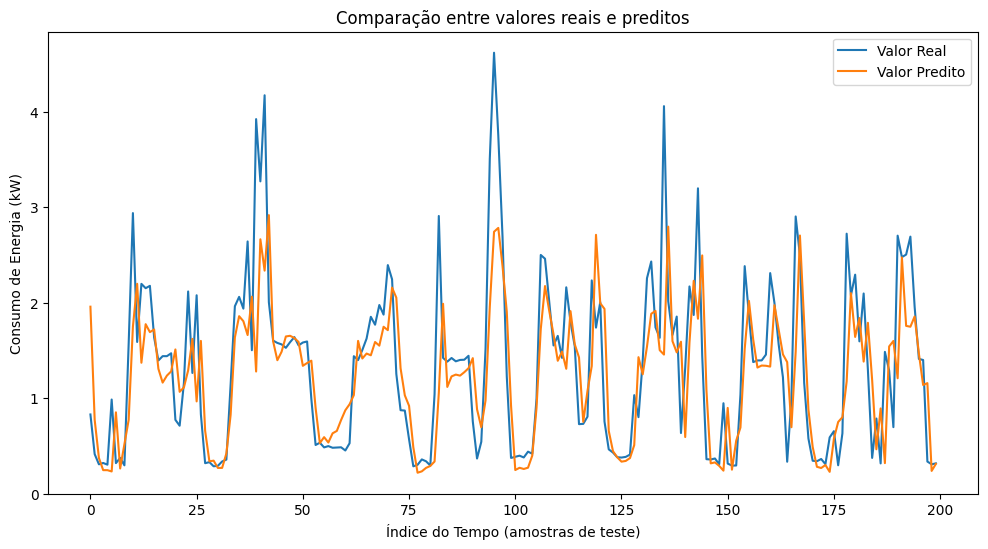

In [8]:
# ==============================
# 5. Visualização das Previsões
# ==============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test[:200], label="Valor Real")       # primeiros 200 pontos de teste
plt.plot(preds[:200], label="Valor Predito")
plt.title("Comparação entre valores reais e preditos")
plt.xlabel("Índice do Tempo (amostras de teste)")
plt.ylabel("Consumo de Energia (kW)")
plt.legend()
plt.show()

## 8. Conclusão

- O modelo **LSTM** foi capaz de aprender padrões temporais do consumo de energia.  
- O valor de **RMSE** mostra o erro médio da previsão em kW.  
- O gráfico mostra que o modelo acompanha as variações principais da série,
apesar de suavizar alguns picos.  
- Este pipeline pode ser expandido para usar múltiplas variáveis (multivariado),
diferentes janelas de tempo, ou arquiteturas mais complexas (Stacked LSTM, GRU, etc.).  